In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #导入seaborn库，用于绘制更加美观的统计图形

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.family']=['Times New Roman', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False #负号不识别问题 
sns.set_style('whitegrid') #设置白色风格
sns.set_palette('muted') #将当前 Seaborn 图表的默认调色板（color palette）设置为 "muted"（柔和）主题
#数据清洗
accidents = pd.read_csv(r'D:/python_demo/coding/data/accid1.csv', encoding='gbk') 
# errors='coerce' 遇到无效格式转换为NaT（时间类型却缺失值）避免转换时报错
accidents['accidenttime'] = pd.to_datetime(accidents['accidenttime'], errors='coerce')

accidents = accidents.dropna(subset=['accidenttime'])
#提取时间特征
accidents['hour'] = accidents['accidenttime'].dt.hour #从中提取小时信息
accidents['weekday'] = accidents['accidenttime'].dt.weekday #返回0-6数据0代表周一
accidents['month'] = accidents['accidenttime'].dt.month #存储1-12

accidents['is_weekday'] = accidents['weekday'].apply(lambda x: "周末" if x >= 5 else "工作日")

def is_peak_hour(hour):
    if hour <= 7 and hour >= 9:
        return '早高峰7-9点'
    elif 17 <= hour <= 19:
        return '晚高峰17-19点'
    else:
        return '非高峰段'
    
accidents['peak_hour'] = accidents['hour'].apply(is_peak_hour)

11

11

In [3]:
accidents.head()

,accidenttime,accidentaddr,driver1fault,driver1responsibility,driver2responsibility,sex1,platenumber1,carcolor1,sex2,platenumber2,...,clpp2,driver1license,driver2license,brith1,brith2,hour,weekday,month,is_weekday,peak_hour
0,2015-02-04 08:23:00,花溪大道北段,7、未按规定让行的,负全部责任,不负责任,1,贵AVG423,白色,1,贵A74653,...,新感觉,36455619349666600,366577000000000000,985082,199006,8,2,2,工作日,非高峰段
1,2015-02-04 08:40:00,花溪区孟关乡,3、倒车的,负全部责任,不负责任,1,贵AKC352,白色,1,贵A6156A,...,起亚牌,354664000000000000,364556000000000000,196904,199402,8,2,2,工作日,非高峰段
2,2015-02-04 07:20:00,白金大道,1、追尾的,负全部责任,不负责任,1,贵A24876,蓝,1,贵AN6491,...,银翔牌,366364000000000000,364558000000000000,196907,198508,7,2,2,工作日,非高峰段
3,2015-02-04 09:20:00,金阳,7、未按规定让行的,负全部责任,不负责任,1,贵A7287L,黑,0,贵A7088C,...,长安牌,366068000000000000,364557000000000000,197512,197906,9,2,2,工作日,非高峰段
4,2015-02-04 09:00:00,新华路,9、不符合前8款规定或者双方同时具有上述情形的,负同等责任,负同等责任,1,贵AU1522,白色,1,贵A68C55,...,海马牌,366577000000000000,364548000000000000,197209,197701,9,2,2,工作日,非高峰段


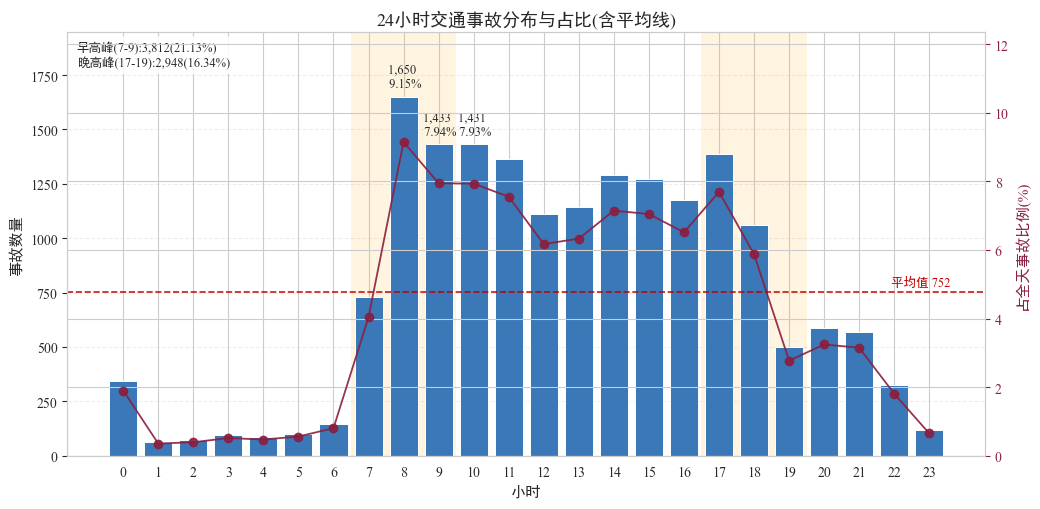

In [4]:
# 事故发生时段-按小时
import pandas as pd # 导入pandas库,用于数据分析和处理
import matplotlib.pyplot as plt # 导入matplotlib.pyplot,用于数据可视化(绘图)
import matplotlib as mpl # 导入matplotlib库,用于更复杂的绘图设置,如字体设置

# 全局设置
plt.rcParams["font.family"] = ["Times New Roman", "SimHei"] # 设置字体, 优先使用Times New Roman (英文), 其次使用SimHei(宋体,中文)
plt.rcParams['axes.unicode_minus'] = False # 解决matplotlib绘图时,负号'-'显示为方块的问题

base_color = '#3A78B7'
peak_span_color = '#FFA500'
line_color = '#8B1E3F'
mean_line_color = '#C00000'

# ===== 数据准备(两种统计口径任选其一) =====
#1)总量口径(与现有hour_df计算逻辑一致):
hour_df = accidents.groupby('hour').size().reset_index(name='count')#按小时分组统计事故数量,size()返回每

#2)(可选)按天平均口径:避免不同天数带来的偏差(如部分小时包含的天数更多),更适合企业对比分析
# accidents['date']= accidents['accidenttime'].dt.date #从事故时间中提取日期(年月日),新增'date'列
# daily_hour = accidents.groupby(['date','hour']).size().reset_index(name='cnt')#按日期和小时双重分组,
# hour_df = daily_hour.groupby('hour')['cnt'].mean().round(2).reset_index(name='count')#按小时分组计算日

# 确保数据按小时从小到大排序
hour_df = hour_df.sort_values('hour',ascending=True).reset_index(drop=True) #按"hour'列升序排序,reset_index(drop=True)重置索引

# ===== 配置:高峰时段窗口与颜色参数 =====
morning_peak=[7,8,9] #定义早高峰时段为7-9点
evening_peak=[17,18,19] #定义晚高峰时段为17-19点
peak_hours= set(morning_peak+evening_peak)# 合并早晚高峰时段,用集合去重(此处无重复,仅统一格式)

# 基础颜色:冷色系蓝色(用于柱状图)
# 高峰阴影颜色:橙色(用于标记高峰时段背景)
# 折线颜色:深红色(用于右轴占比折线)
# 均值线颜色:红色(用于标记平均事故数水平线)

# ===== 计算百分比与均值 =====
total= hour_df['count'].sum()#计算全天24小时的事故总数
pct=hour_df['count']/total* 100.0 # 计算每个小时的事故数占全天总数的百分比,存为pct
mean_val=hour_df['count'].mean()#计算24小时的平均事故数,作为参考基准

# ===== 开始绘图 =====
fig, ax=plt.subplots(figsize=(10.5,5.2))#创建画布和子图,设置画布大小为10.5x5.2英寸

# 绘制高峰时段阴影(x轴为小时整数,阴影范围向左右各扩展0.5以覆盖整小时区间)
# 早高峰阴影:覆盖6.5-9.5(即7-9点),颜色
# 晚高峰阴影:覆盖16.5-19.5(即17-19点),

ax.axvspan(6.5, 9.5, color=peak_span_color, alpha=0.12, lw=0)
ax.axvspan(16.5, 19.5, color=peak_span_color, alpha=0.12, lw=0)

#绘制柱状图(事故数量)
bars = ax.bar(
hour_df['hour'],#x轴数据:小时(0-23)
hour_df['count'],#y轴数据:每个小时的事故数量
color=base_color,#柱子颜色为base_color
edgecolor='white',#柱子边框为白色
linewidth=0.7 # 边框线宽0.7,增强清晰度

)

# 设置左轴标题与坐标轴标签
ax.set_title('24小时交通事故分布与占比(含平均线)',fontsize=13)#设置图表标题,字体大小13'
ax.set_xlabel('小时',fontsize=11)#设置x轴标签为“小时”,字体大小11
ax.set_ylabel('事故数量',fontsize=11)#设置左y轴标签为“事故数量”,字体大小11
ymax=hour_df['count'].max()#获取事故数量的最大值
ax.set_ylim(0,ymax* 1.18) #设置左y轴范围:从0到最大值的1.18倍

# 添加网格线(仅y轴,增强读数参考)
ax.grid(axis='y',linestyle='--',alpha=0.35)#仅在y轴添加虚线网格,透明度0.35

# 绘制均值虚线(标记24小时平均事故数)
ax.axhline(mean_val, color=mean_line_color, linestyle='--', lw=1.2, alpha=0.9)#绘制水平虚线,y值为mean_V
ax.text(
23.6,mean_val* 1.02,# 文本位置:x=23.6(接近右边缘),y=均值的1.02倍(略高于线)
f'平均值 {mean_val :.0f}',#文本内容:平均值加整数显示
color=mean_line_color, fontsize=9, ha='right', va='bottom'

# 文本颜色与均值线一致,字体9号,右对齐,底部

)

#创建右轴,绘制占比折线图
ax2=ax.twinx()#共享x轴,创建双y轴(右轴)
ax2.plot(
hour_df['hour'], pct,#x轴为小时,y轴为百分比数据pct
marker='o',linewidth=1.3,alpha=0.9,#折线带圆形标记,线宽1.3,透明度0.9
color=line_color #折线颜色为Line_color
)
ax2.set_ylabel('占全天事故比例(%)',fontsize=11,color=line_color)#设置右y轴标签,字体11号,颜色与折线一
ax2.tick_params(axis='y',colors=line_color)#右y轴刻度颜色与折线一致
ax2.set_ylim(0,pct.max()*1.35)#右y轴范围:从0到最大百分比的1.35倍,预留空间

# 在顶部标注事故数量Top3的小时(按数量排序)
def fmt_pct(n):
    return f"{n/total*100 :.2f}%" #定义百分比格式化函数:将数值n转换为占总数的百分比,保留2位小数
top3=hour_df.nlargest(3,'count')#筛选事故数量排名前三的小时数据
for _, r in top3.iterrows():#遍历Top3的每一行数据
    ax.text(
    r['hour'],r['count']*1.02,#文本位置:x为小时,y为该小时事故数的1.02倍(柱子顶部上方)
    f"{int(r['count']):,} \n {fmt_pct(r['count'])}",#文本内容:事故数(整数+千分位分隔)+换行+百分比
    ha='center', va='bottom',fontsize=9 #水平居中,垂直底部对齐,字体9号
    )
# 在图表角落标注早晚高峰的事故总数及占比
morning_sum = hour_df.loc[hour_df['hour'].isin(morning_peak),'count'].sum()#计算早高峰时段(7-9点)的事
evening_sum = hour_df.loc[hour_df['hour'].isin(evening_peak),'count'].sum()#计算晚高峰时段(17-19点)的
ax.text(
0.01,0.98,#文本位置:相对于子图的比例坐标(左边缘1%,上边缘2%)
f"早高峰(7-9):{morning_sum:,}({fmt_pct(morning_sum)})\n" #早高峰数据:总数(千分位)+占比
f"晚高峰(17-19):{evening_sum:,}({fmt_pct(evening_sum)})",#晚高峰数据:同上
transform=ax.transAxes, ha='left', va='top',fontsize=9,#使用相对坐标,左对齐,顶部对齐,字体9号
bbox=dict(boxstyle='round,pad=0.35', facecolor='white', alpha =.85, lw=0)#添加白色半透明背景框,圆角,
)
ax.set_xticks(range(0, 24, 1)) #设置X轴刻度, 从0到23, 每隔2个显示一个
plt.tight_layout() #自动调整子图参数, 使之填充整个图像区域, 避免标签重叠
plt.show() #显示图表



    hour  avg_per_hour
8      8         14.35
9      9         12.46
10    10         12.44


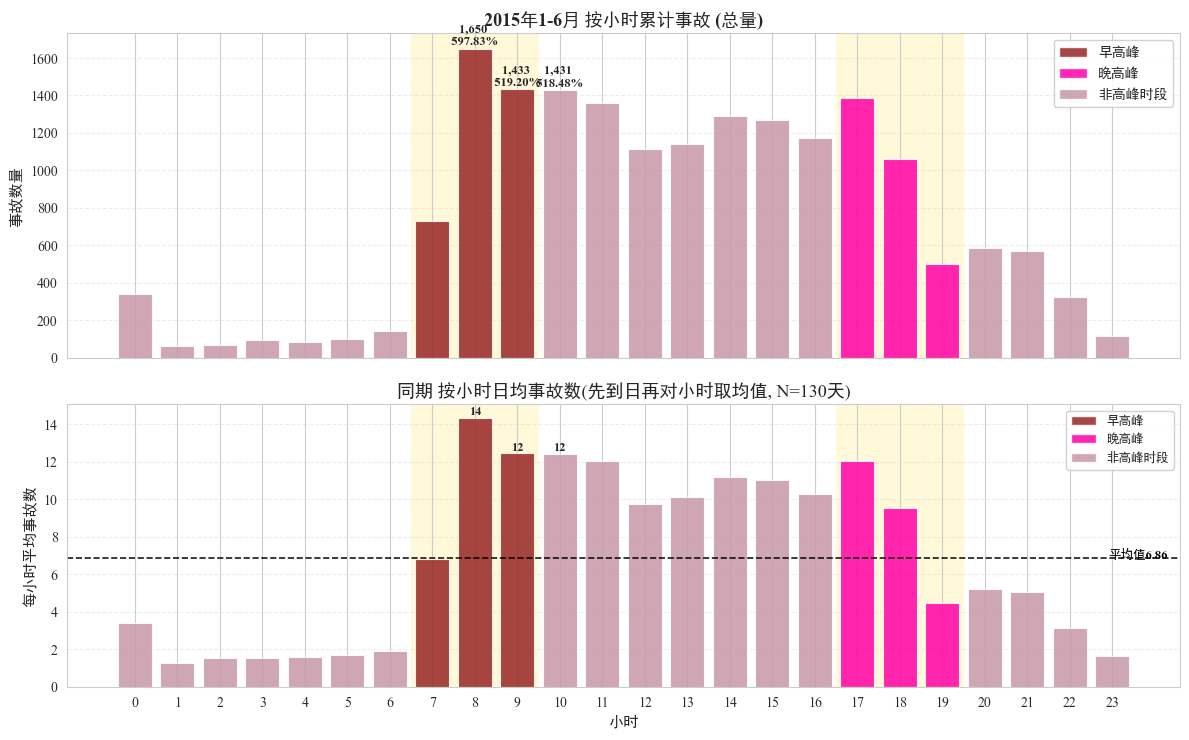

In [5]:
# 事故发生时段-按小时
import pandas as pd # 导入pandas库,用于数据分析和处理
import matplotlib.pyplot as plt # 导入matplotlib.pyplot,用于数据可视化(绘图)
import matplotlib as mpl # 导入matplotlib库,用于更复杂的绘图设置,如字体设置
from matplotlib.patches import Patch #导入Patch类，用于定义图例元素

# 全局设置
plt.rcParams["font.family"] = ["Times New Roman", "SimHei"] # 设置字体, 优先使用Times New Roman (英文), 其次使用SimHei(宋体,中文)
plt.rcParams['axes.unicode_minus'] = False # 解决matplotlib绘图时,负号'-'显示为方块的问题

accidents['accidenttime'] = pd.to_datetime(accidents['accidenttime'], errors='coerce')
accidents = accidents.dropna(subset=['accidenttime'])
accidents['hour'] = accidents['accidenttime'].dt.hour
accidents['date'] = accidents['accidenttime'].dt.date

hour_total=(
    accidents.groupby('hour').size()
    .reindex(range(24), fill_value=0) #确保0-23小时都有值
    .reset_index(name='count')
    .rename(columns={'index':'hour'}) 
)
daily_hour = (
    accidents.groupby(['date', 'hour'])
    .size().reset_index(name='cnt')
)
N_days = daily_hour['date'].nunique() #计算总天数
hour_mean = (
    daily_hour.groupby('hour')['cnt'].mean().reindex(range(24), fill_value=0.0).round(2)
    .reset_index(name='avg_per_hour')
    .rename(columns={'index':'hour'})
)
morning_peak = [7, 8, 9]
evening_peak = [17, 18, 19]
morning_color = "#972525" #
evening_color = "#FF00A6" #晚高峰显示
normal_color = "#C797A6" #非高峰颜色
mean_line_color = "#000000" #均值线显示

#定义函数
def get_bar_color(hour):
    """"根据小时判断所属时段，返回对应的柱子颜色"""
    if hour in morning_peak:
        return morning_color
    elif hour in evening_peak:
        return evening_color
    else: #非高峰时段
        return normal_color
    
global_avg = hour_mean['avg_per_hour'].mean()

fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, #创建两行一列的子图布局
    figsize=(12, 7.5), #画布大小为7.5 * 12英寸
    sharex=True, #两张图共享x，确保横轴刻度一致
    gridspec_kw={'height_ratios':[1.15, 1.0]} #上下图高度比例为1.15：1.0上图略高随意自己太哦
)
#上图：累计和
#绘制透明区域背景
ax1.axvspan(6.5, 9.5, color='#FFD700', alpha=0.15, lw=0, zorder=0)#zorder图层优先级为0在底层
ax1.axvspan(16.5, 19.5, color='#FFD700', alpha=0.15, lw=0, zorder=0)#zorder图层优先级为0在底层
color1 = [get_bar_color(h) for h in hour_total['hour']]
bars1 = ax1.bar(
    hour_total['hour'],
    hour_total['count'],
    color=color1,
    edgecolor='white',
    linewidth=0.8,
    alpha=0.85,
    zorder=2
)
ax1.set_title('2015年1-6月 按小时累计事故 (总量)', fontsize=13, fontweight='bold')
ax1.set_ylabel('事故数量', fontsize=11) #y轴标签,累计事故数量
ax1.grid(axis='y', linestyle='--', alpha=0.35)
#标注上图事故数量排名前三小时突出关键时段
top3_total=hour_total.nlargest(3, 'count')
# print(top3_total)
sum_total = hour_total['hour'].sum()
for _, r in  top3_total.iterrows():
    pct = r['count'] / sum_total * 100 if sum_total > 0 else 0
    ax1.text(
        r['hour'], r['count']*1.02,
        f"{int(r['count']):,} \n {pct:.2f}% \n",
        ha='center', va='center', fontsize=9, fontweight='bold'
    )
legend_elementsl = [
    Patch(facecolor=morning_color, alpha=0.85, label='早高峰'),
    Patch(facecolor=evening_color, alpha=0.85, label='晚高峰'),
    Patch(facecolor=normal_color, alpha=0.85, label='非高峰时段'),
]
ax1.legend(handles=legend_elementsl, loc=1, framealpha=0.9)#framealpha=0.9透明底为0.9

ax2.axvspan(6.5, 9.5, color='#FFD700', alpha=0.15, lw=0, zorder=0)#zorder图层优先级为0在底层
ax2.axvspan(16.5, 19.5, color='#FFD700', alpha=0.15, lw=0, zorder=0)#zorder图层优先级为0在底层
color2 = [get_bar_color(h) for h in hour_total['hour']]
bars2 = ax2.bar(
    hour_total['hour'],
    hour_mean['avg_per_hour'], #每小时平均事故数
    color=color2,
    edgecolor='white',
    linewidth=0.8,
    alpha=0.85,
    zorder=2
)
#绘制日均事故数的平均虚线
ax2.axhline(
    global_avg,
    color=mean_line_color,
    linestyle='--',
    lw=1.2, alpha=0.9
)
ax2.text(
    23.6,
    global_avg*1.02,
    f'平均值{global_avg:.2f}',
    color=mean_line_color, fontsize=9, ha='center', va='center', fontweight='bold'
)
ax2.set_title(
    f'同期 按小时日均事故数(先到日再对小时取均值, N={N_days}天)',
    fontsize=13,
)
ax2.set_xlabel('小时', fontsize=11)
ax2.set_ylabel('每小时平均事故数', fontsize=11)
ax2.grid(axis='y', linestyle='--', alpha=0.35)

top3_mean = hour_mean.nlargest(3, 'avg_per_hour')
print(top3_mean)
for _, r in top3_mean.iterrows():
    ax2.text(
        r['hour'], r['avg_per_hour']*1.02,
        f"{int(r['avg_per_hour']):,}",
        ha='center', va='center', fontsize=9, fontweight='bold'
    )
legend_elements2 = [
    Patch(facecolor=morning_color, alpha=0.85, label='早高峰'),
    Patch(facecolor=evening_color, alpha=0.85, label='晚高峰'),
    Patch(facecolor=normal_color, alpha=0.85, label='非高峰时段'),
]
ax2.legend(handles=legend_elements2, loc=1, framealpha=0.9 ,fontsize=9)#framealpha=0.9透明底为0.9
ax2.set_xticks(range(0, 24, 1))
plt.tight_layout()
plt.show()


date        weekday
2015-01-02  4            1
2015-01-05  0            2
2015-01-06  1            1
2015-01-07  2            1
2015-01-08  3            1
                      ... 
2015-05-27  2          147
2015-05-28  3          144
2015-05-29  4          182
2015-05-30  5          144
2015-05-31  6            4
Length: 130, dtype: int64
             date  weekday
0      2015-02-04        2
1      2015-02-04        2
2      2015-02-04        2
3      2015-02-04        2
4      2015-02-04        2
...           ...      ...
18036  2015-05-10        6
18037  2015-02-05        3
18038  2015-04-16        3
18039  2015-02-12        3
18040  2015-03-16        0

[18041 rows x 2 columns]


Text(0, 1, '工作日:13081(72.51%) 日均139.2 \n周末:4960(27.49%) 日均137.8')

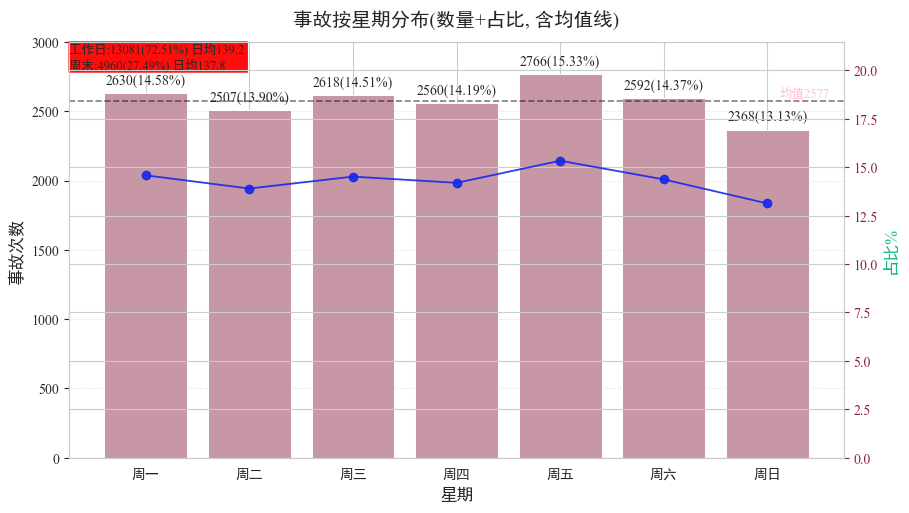

In [ ]:
import matplotlib.pyplot as plt # 导入matplotlib.pyplot,用于数据可视化(绘图)
import matplotlib as mpl # 导入matplotlib库,用于更复杂的绘图设置,如字体设置
from matplotlib.patches import Patch #导入Patch类，用于定义图例元素

weekday_counts = accidents['weekday'].value_counts().sort_index() #.value_counts()生成频数
weekday_labels = ['周一','周二','周三','周四','周五','周六', '周日']
x = np.arange(7)
y = weekday_counts.values
total = y.sum()
pct = y/total * 100 
colors = ['#9cdcfe'] * 5 + ['#c586b6'] * 2
fig, ax = plt.subplots(figsize=(10, 5.4))

bars = ax.bar(
    x, 
    y,
    color=color1,
    edgecolor='white',
    linewidth=0.7,
)
#设置左轴标题和坐标轴标签
ax.set_title('事故按星期分布(数量+占比, 含均值线)', fontsize=14, pad=12) #pd为距离顶部距离
ax.set_xlabel('星期', fontsize=12)
ax.set_ylabel('事故次数', fontsize=12)
ax.set_xticks(x)
ax.set_ylim(0, 3000)
ax.set_xticklabels(weekday_labels) #将x轴刻度替换为星期名
ax.grid(axis='y', linestyle='--', alpha=0.35) #添加y轴虚线网络，透明度为0.35

mean_val = y.mean()
ax.axhline( #绘制水平线
    mean_val, #水平线y值：平均值
    color='black',
    ls='--',
    lw=1.2,
    alpha=0.5
)
ax.text(
    6.6, mean_val * 1,
    f'均值{mean_val:.0f}', #平均文本内容取整数
    color='pink',ha='right', va='bottom', fontsize=9
)
ax2 = ax.twinx()
ax2.plot(
    x,
    pct,
    color='#1429ed',
    marker='o', #数据点标记：园形
    lw=1.3, alpha=.9
)
ax2.set_ylabel('占比%', fontsize=12, color='#0dbc79')
ax2.tick_params(axis='y', colors='#8B1E3F') #又y轴颜色和折现一致
ax2.set_ylim(0, pct.max()*1.4)

ymax = y.max()
for xi, yi, pi in zip(x, y, pct):
    ax.text(
        xi, yi + ymax*0.015,
        f'{int(yi)}({pi:.2f}%)',
        ha='center', va='bottom',
    )

accidents['date'] = accidents['accidenttime'].dt.date
# accidents.head()
by_day = accidents.groupby(['date', 'weekday']).size().reset_index(name='cnt')
# print(accidents.groupby(['date', 'weekday']).size())
# print(accidents.loc[:, ['date', 'weekday']])
wk_avg = by_day.loc[by_day['weekday'].isin(range(5)), 'cnt'].mean()
we_avg = by_day.loc[by_day['weekday'].isin([5, 6]), 'cnt'].mean()
wk_sum = y[:5].sum()
we_sum = y[5:].sum()
ax.text(
    0, 1, #相对子图的比例坐标(左边缘1.5%， 上边缘2%)
    f'工作日:{wk_sum}({wk_sum/total*100:.2f}%) 日均{wk_avg:.1f} \n'
    f'周末:{we_sum}({we_sum/total*100:.2f}%) 日均{we_avg:.1f}', #周末数据#周末数据

    transform=ax.transAxes, ha='left', va='top', fontsize=9, #transform=ax.transAxes告诉其适用相对坐标器不使用坐标器
     bbox=dict(boxstyle='round,pad=0.05', facecolor='red', alpha=.95, lw=0) #ax.transAxes相对坐标左对其
)

正在读取数据


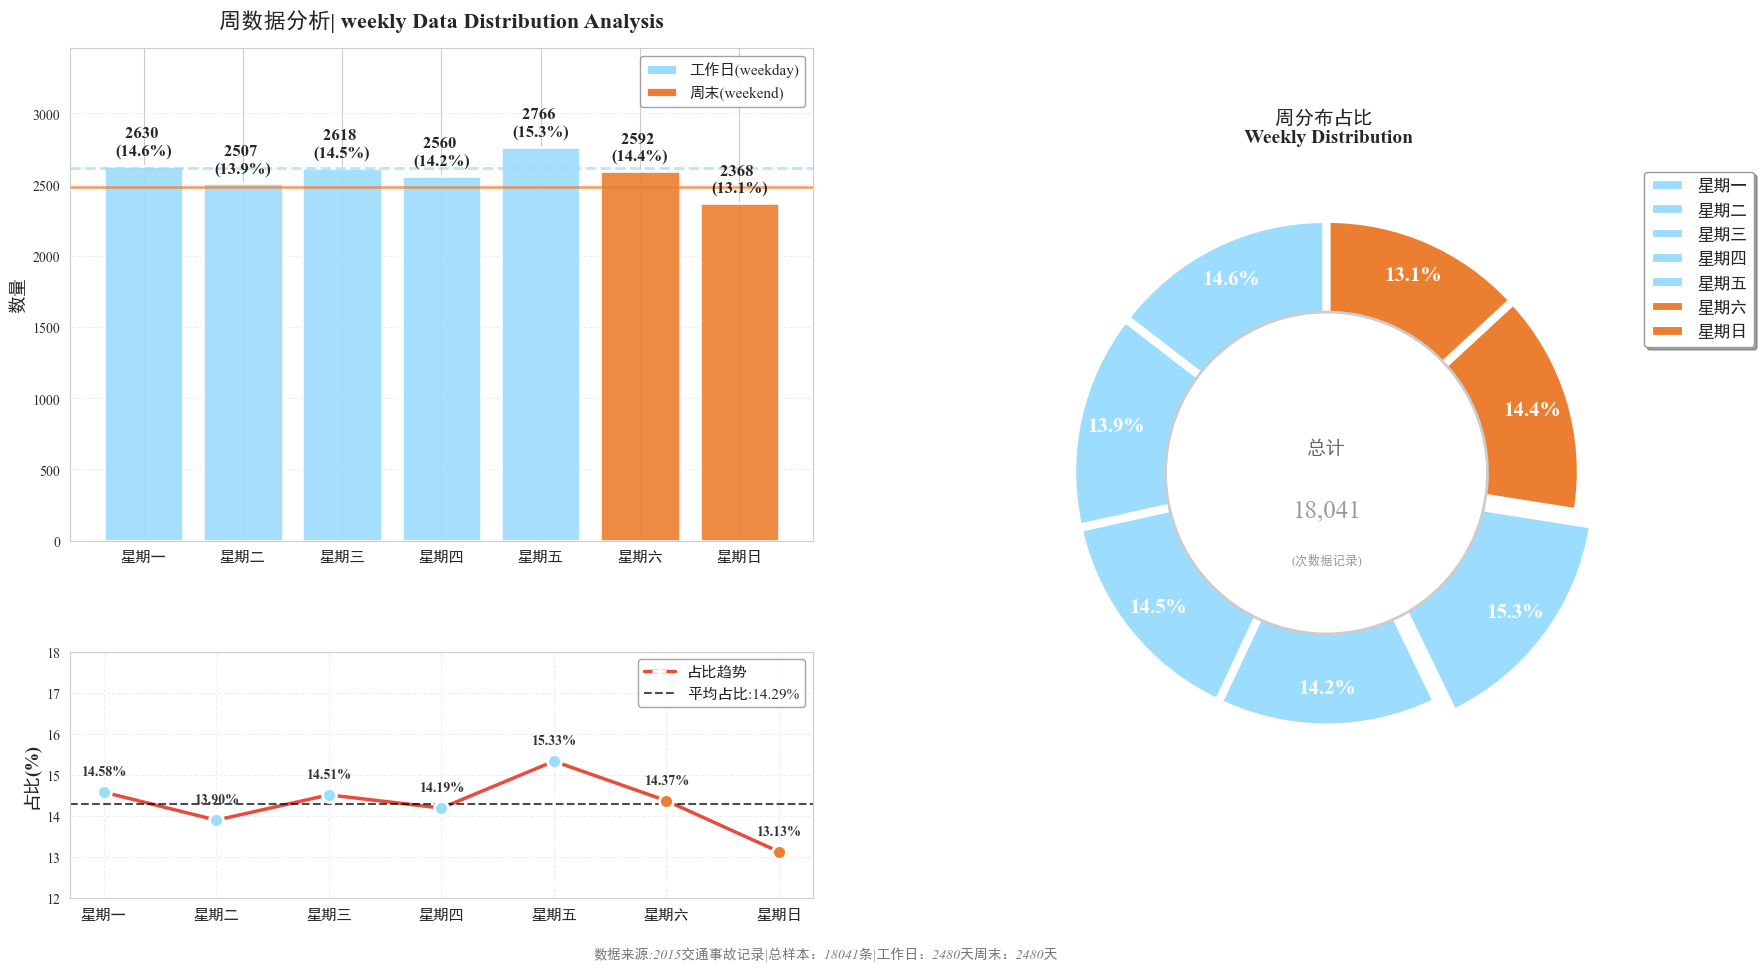

weekday                  0
count                 2630
星期                     星期一
percentage       14.577906
type          工作日(weekday)
Name: 0, dtype: object
weekday                  1
count                 2507
星期                     星期二
percentage       13.896125
type          工作日(weekday)
Name: 1, dtype: object
weekday                  2
count                 2618
星期                     星期三
percentage       14.511391
type          工作日(weekday)
Name: 2, dtype: object
weekday                  3
count                 2560
星期                     星期四
percentage       14.189901
type          工作日(weekday)
Name: 3, dtype: object
weekday                  4
count                 2766
星期                     星期五
percentage       15.331744
type          工作日(weekday)
Name: 4, dtype: object
weekday                 5
count                2592
星期                    星期六
percentage      14.367275
type          周末(weekend)
Name: 5, dtype: object
weekday                 6
count                2368
星期   

In [ ]:
import matplotlib.pyplot as plt # 导入matplotlib.pyplot,用于数据可视化(绘图)
from matplotlib import gridspec,  patches #gridspec导入创建复杂子图布局，patches自定义图例元素

import pandas as pd
import numpy as np

plt.rcParams["font.family"] = ["Times New Roman", "SimHei"] # 设置字体, 优先使用Times New Roman (英文), 其次使用SimHei(宋体,中文)
plt.rcParams['axes.unicode_minus'] = False # 解决matplotlib绘图时,负号'-'显示为方块的问题
print('正在读取数据')
try:
    accidents = pd.read_csv(r'D:/python_demo/coding/data/accid1.csv', encoding='gbk')
except:
    print('gbk编码方式不兼容换cp1252')
    accidents = pd.read_csv(r'D:/python_demo/coding/data/accid1.csv', encoding='cp1252')
accidents.head()

#数据处理
accidents['accidenttime'] = pd.to_datetime(accidents['accidenttime'], errors='coerce')
accidents = accidents.dropna(subset=['accidenttime'])

accidents['weekday'] = accidents['accidenttime'].dt.weekday
accidents['weekday_name'] = accidents['weekday'].map({
    0:'星期一',1:'星期二',2:'星期三',3:'星期四',4:'星期五',5:'星期六',6:'星期日'
}
)
accidents['is_weekend'] = accidents['weekday'].apply(
    lambda x: '周末' if x >= 5 else "工作日"
)
weekday_stats = accidents.groupby('weekday').agg({
    'accidenttime':'count'
}).reset_index()
weekday_stats.columns = ['weekday', 'count']
weekday_stats = weekday_stats.sort_values('weekday')
weekday_stats['星期'] = weekday_stats['weekday'].map({
    0:'星期一',1:'星期二',2:'星期三',3:'星期四',4:'星期五',5:'星期六',6:'星期日'
}
)
weekday_stats
total = weekday_stats['count'].sum()
weekday_stats['percentage'] = weekday_stats['count'] / total * 100
weekday_stats['type'] = weekday_stats['weekday'].apply(
    lambda x: '周末(weekend)' if x >= 5 else '工作日(weekday)'
)
weekday_avg = weekday_stats[weekday_stats['weekday'] < 5] ['count'].mean()
weekend_avg = weekday_stats[weekday_stats['weekday'] >= 5] ['count'].mean()
fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 2, figure=fig,
              height_ratios=[2, 1],
              width_ratios=[1.2, 1],
              hspace=0.3, 
              wspace=0.3,
              left=0.08, right=0.95, top=0.93, bottom=0.08)
color_weekday = '#9cdcfe' 
color_weekend = '#ec7e31' 

#左上柱状图
ax1 = fig.add_subplot(gs[0, 0]) #定位到1行1列
x_pos = np.arange(len(weekday_stats))

colors = [color_weekday if wd<5 else color_weekend for wd in weekday_stats['weekday']]
#绘制柱状图
bars = ax1.bar(x_pos, weekday_stats['count'],
               color=colors,
               edgecolor='white',
               linewidth=2,
               alpha=0.9)
ax1.axhline(y=weekday_avg, color=color_weekday, linestyle='--', linewidth=2, alpha=.7, label=f'工作日均值:{int(weekday_avg)}')
#周末平均线
ax1.axhline(y=weekend_avg, color=color_weekend, linewidth=2, alpha=0.7, label=f'周末均值{int(weekend_avg)}')
#在柱子上添加百分比标注
for i, (bar, row) in enumerate(zip(bars, weekday_stats.itertuples())):
    height = bar.get_height() #获取柱子高度
    ax1.text(
        bar.get_x() + bar.get_width()/2,
        height + 50,
        f'{int(height)} \n'f'({row.percentage:.1f}%)',
        ha='center', va='bottom', fontsize=12, fontweight='bold'
    )
    # ax1.text(bar.get_x() + bar.get_width()/2,
    #          height + 120,
    #          f'({row.percentage:.1f}%)',
    #          ha='center', va='bottom', fontsize=12, color='#555')
ax1.set_title('周数据分析| weekly Data Distribution Analysis',
              fontsize=16, fontweight='bold', pad=15)
ax1.set_ylabel('数量', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(weekday_stats['星期'], fontsize=11)
ax1.set_ylim(0, weekday_stats['count'].max() * 1.25)
ax1.grid(axis='y', ls='--', alpha=0.3)
legend_elements = [
    patches.Patch(facecolor=color_weekday, edgecolor='white', label='工作日(weekday)', linewidth=2),
    patches.Patch(facecolor=color_weekend, edgecolor='white', label='周末(weekend)', linewidth=2)
]
ax1.legend(handles=legend_elements, loc=1, fontsize=11, framealpha=0.9, edgecolor='#999')

ax2 = fig.add_subplot(gs[1, 0])
line_colors = [color_weekday if wd<5 else color_weekend for wd in weekday_stats['weekday']]

ax2.plot(
    x_pos, weekday_stats['percentage'],
    marker='+', markersize=10, linewidth=2.5, color='#E74C3C',
    markerfacecolor='#E74C3C', #标记填充色
    markeredgecolor='white', #标记边框色
    markeredgewidth=2,
    label='占比趋势'
)
for i, (x, y, color) in enumerate(zip(x_pos, weekday_stats['percentage'], colors)):
    ax2.plot(
        x, y, 'o',
        markersize=10,color=color, markeredgecolor='white',markeredgewidth=2, zorder=3,
    )
avg_percentage = weekday_stats['percentage'].mean()
ax2.axhline(
    avg_percentage,
    color='#000000',
    linestyle='--',
    linewidth=1.5,
    alpha=0.7,
    label=f'平均占比:{avg_percentage:.2f}%'
)
for x, y in zip(x_pos, weekday_stats['percentage']):
    ax2.annotate(  #标注内容：百分比
        f'{y:.2f}%',
        xy=(x, y),
        xytext=(0, 10),
        textcoords='offset points', #偏移点， 偏移方式：相对点偏移
        ha='center', va='bottom',
        fontsize=10,
        fontweight='bold',
        color='#333'
    )
#设置标题和标签、
ax2.set_ylabel('占比(%)', fontsize=13, fontweight='bold')
ax2.set_xlabel('', fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos) #x轴刻度位置
ax2.set_xticklabels(weekday_stats['星期'], fontsize=11) #x轴刻度标签
ax2.set_ylim(12, 18)
ax2.grid(True, linestyle='--', alpha=0.3)
ax2.legend(loc=1, fontsize=11, framealpha=0.9, edgecolor='#999')

#右侧：环形饼图
ax3 = fig.add_subplot(gs[:, 1])
pie_colors = [color_weekday if wd < 5 else color_weekend for wd in weekday_stats['weekday']]
#设置各部分的分离距离
explode = [0.1 if wd== 4 else 0.02 for wd in weekday_stats['weekday']]

wedges, texts, autotexts = ax3.pie(
    weekday_stats['count'],
    labels=None,
    autopct='%1.1f%%', #自动计算并显示百分比
    startangle=90, #从正上方开始绘制
    colors=pie_colors, 
    explode=explode, #应用分离设置
    wedgeprops={'edgecolor':'white', 'linewidth':3}, #扇形边框：白色，线宽为3
    textprops={'fontsize':15, 'fontweight':'bold', 'color':'white'}, #百分比文本样式
    pctdistance=0.85 #百分比文本样式距离圆心的相对位置
)
centre_circle = plt.Circle((0, 0), 0.65,  #圆心和半径
                           fc='white', linewidth=2, edgecolor='#CCC')
ax3.add_artist(centre_circle) #将白色圆圈添加到子图
ax3.text(0, 0.1, '总计', ha='center', va='center', color='#666', fontsize=14, fontweight='bold')
ax3.text(0, -0.35, '(次数据记录)',ha='center',fontsize=9, va='center', color='#999')
ax3.text(0, -0.15, f'{total:,}',ha='center', va='center', color='#999',fontsize=18,)
#添加图列
lengend_labels = [f'{row.星期}' for _, row in weekday_stats.iterrows()] #每列
ax3.legend(
    wedges, lengend_labels,
    loc=2, 
    bbox_to_anchor=(1, 0, 0.5, 1), #调整图例位置
    fontsize=12,
    title_fontsize=13,
    frameon=True, #显示边框
    fancybox=True, #圆角边框
    shadow=True, #阴影效果
    edgecolor='#999'
)
ax3.set_title('周分布占比 \n Weekly Distribution',
              fontsize=14, fontweight='bold', pad=15)
#添加页脚说明
note_text = (f'数据来源:2015交通事故记录|'f'总样本：{total}条|' f'工作日：{weekend_avg:.0f}天'f'周末：{weekend_avg:.0f}天')
fig.text(0.5, 0.02, note_text, ha='center', fontsize=10, color='#777', style='italic') #style斜体灰色小子

plt.show()

